<img src="../../../Other/img/注意力机制.png"  style="width:750px;height:400px;float:bottom">

其中$a$表示注意力评分函数

假设有一个查询$ \mathrm{q} \in \mathbb{R}^{q} $ 和$m$个"键-值"对$ \left(\mathrm{k}_{1}, \mathrm{v}_{1}\right), \ldots,\left(\mathrm{k}_{m}, \mathrm{v}_{m}\right) $,其中$ \mathrm{k}_{i} \in \mathbb{R}^{k}, \mathrm{v}_{i} \in \mathbb{R}^{v}$.注意力汇聚函数$f$就被表示成值的加权和:

$$ f\left(\mathrm{q},\left(\mathrm{k}_{1}, \mathrm{v}_{1}\right), \ldots,\left(\mathrm{k}_{m}, \mathrm{v}_{m}\right)\right)=\sum^{m} \alpha\left(\mathrm{q}, \mathrm{k}_{i}\right) \mathrm{v}_{i} \in \mathbb{R}^{v} $$

其中查询$\mathrm{q}$和键$\mathrm{k}_i$的注意力权重是通过注意力评分函数$a$将两个向量映射为标量,再经过softmax运算得到:

$$ \alpha\left(\mathrm{q}, \mathrm{k}_{i}\right)=\operatorname{softmax}\left(a\left(\mathrm{q}, \mathrm{k}_{i}\right)\right)=\frac{\exp \left(a\left(\mathrm{q}, \mathrm{k}_{i}\right)\right)}{\sum_{j=1}^{m} \exp \left(a\left(\mathrm{q}, \mathbf{k}_{j}\right)\right)} \in \mathbb{R} $$

选择不同的注意力评分函数$ a $会导致不同的注意力汇聚操作

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


def masked_softmax(X, valid_lens=None):
    """通过在最后⼀个轴上遮蔽元素来执⾏softmax操作"""

    def sequence_mask(X, valid_len, value=0):
        """Mask irrelevant entries in sequences"""
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 被遮蔽的元素使⽤⼀个非常大的负值替换,使其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return F.softmax(X.reshape(shape), dim=-1)

In [10]:
print(masked_softmax(torch.rand(2, 2, 4)), end='\n\n')
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])), end='\n\n')
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]])))

tensor([[[0.2541, 0.3160, 0.2905, 0.1394],
         [0.1437, 0.3130, 0.1746, 0.3687]],

        [[0.1897, 0.3926, 0.2209, 0.1967],
         [0.3047, 0.3155, 0.1471, 0.2327]]])

tensor([[[0.6147, 0.3853, 0.0000, 0.0000],
         [0.5843, 0.4157, 0.0000, 0.0000]],

        [[0.2682, 0.4231, 0.3087, 0.0000],
         [0.2271, 0.4574, 0.3155, 0.0000]]])

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3281, 0.2891, 0.3827, 0.0000]],

        [[0.3449, 0.6551, 0.0000, 0.0000],
         [0.1765, 0.1535, 0.3400, 0.3299]]])


### 加性注意力

当查询和键是不同长度的矢量时,可以使⽤加性注意力作为评分函数.给定查询$ \mathrm{q} \in \mathbb{R}^{1 \times q} $和键$\mathrm{k} \in \mathbb{R}^{1 \times k} $,加性注意力(additive attention)的评分函数为:

$$ a(\mathrm{q}, \mathrm{k})=\tanh \left(\mathrm{q} W_q^T + \mathrm{k} W_k^T\right) \mathrm{w}_{v} \in \mathbb{R} $$

其中可学习的参数是$ W_q \in \mathbb{R}^{h \times q}, W_k \in \mathbb{R}^{h \times k} $和$\mathrm{w}_v \in \mathbb{R}^{h \times 1}$.
然后将查询和键连接起来后输⼊到⼀个多层感知机(MLP)中,感知机包含⼀个隐藏层,其隐藏单元数是⼀个超参数$h$.通过使用tanh作为激活函数,并且禁用偏置项

In [11]:
class AdditiveAttention(nn.Module):
    """加性注意⼒"""

    def __init__(self, key_size, query_size, num_hiddens, dropout):
        super(AdditiveAttention, self).__init__()
        # self.W_k.weight.shape = (num_hiddens, key_size)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        # self.W_q.weight.shape = (num_hiddens, query_size)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        # self.W_v.weight.shape = (1, num_hiddens)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # queries:(b, ?q, query_size) x (query_size, num_hiddens) = (b, ?q, num_hiddens)
        # keys:(b, ?k, key_size) x (key_size, num_hiddens) = (b, ?k, num_hiddens)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries.unsqueeze(2).shape=(b, ?q, 1, num_hiddens)
        # keys.unsqueeze(1).shape=(b, 1, ?k, num_hiddens)
        # features.shape=(b, ?q, ?k, num_hiddens)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # scores:(b, ?q, ?k, num_hiddens) x (num_hiddens, 1) = (b, ?q, ?k, 1)
        # scores.squeeze(-1).shape=(b, ?q, ?k)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values.shape=(b, ?k, ?v)
        # 返回值:(b, ?q, ?k) x (b, ?k, ?v) = (b, ?q, ?v)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [12]:
# queries.shape(2, 1, 10)
# keys.shape=(2, 10, 2)
# values.shape=(2, 10, 4)
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
# 最终结果.shape=(2, 1, 4)
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

In [13]:
attention.attention_weights

tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)

Text(33.0, 0.5, 'Queries')

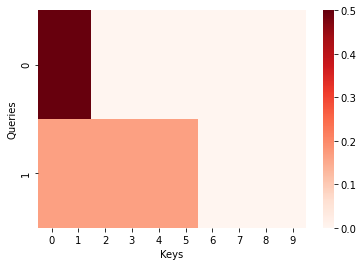

In [14]:
# 注意力权重
_, axes = plt.subplots(1, 1)
sns.heatmap(torch.squeeze(attention.attention_weights.detach(), 1), cmap='Reds', ax=axes)
axes.set_xlabel('Keys')
axes.set_ylabel('Queries')

### 缩放点积注意力

使用点积可以得到计算效率更⾼的评分函数.但是点积操作要求查询和键具有相同的⻓度$ d $.

缩放点注意力(scaled dot-product attention)评分函数:

$$ a(\mathrm{q}, \mathrm{k})=\mathrm{q} \mathrm{k}^T / \sqrt{d} $$

向量化版本:

1. $$ Q \in \mathbb{R}^{n \times d}, \quad K \in \mathbb{R}^{m \times d}, V \in \mathbb{R}^{m \times v} $$

2. 注意力分数: $$ a(Q, K)=Q K^{T} / \sqrt{d} \in \mathbb{R}^{n \times m}$$

3. 注意力汇聚:$$ f=\operatorname{softmax}(a(Q,K)) V \in \mathbb{R}^{n \times v} $$

In [15]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""

    def __init__(self, dropout):
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    # queries.shape = (b, ?q, d)
    # keys.shape = (b, ?k, d)
    # scores.shape = (b, ?q, d) x (b, d, ?k) = (b, ?q, ?k)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [16]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
# 最终结果.shape=(2, 1, 4)
attention = DotProductAttention(dropout=0.5)

attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

Text(33.0, 0.5, 'Queries')

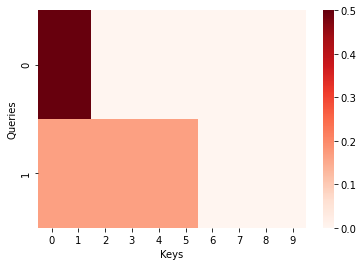

In [17]:
# 注意力权重
_, axes = plt.subplots(1, 1)
sns.heatmap(torch.squeeze(attention.attention_weights.detach(), 1), cmap='Reds', ax=axes)
axes.set_xlabel('Keys')
axes.set_ylabel('Queries')

In [1]:
import torch.nn as nn
a = nn.Linear(3, 1, bias=False)

In [2]:
a.weight.shape

torch.Size([1, 3])